# Word Embedding - Home Assigment
## Dr. Omri Allouche 2021-2022. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/ydata_deep_learning_2021/blob/master/assignments/word_vectors_text_classification/DL_word_embedding_assignment.ipynb)

    
In this exercise, you'll use word vectors trained on a corpus of lyrics of songs from MetroLyrics http://github.com/omriallouche/ydata_deep_learning_2021/blob/master/data/metrolyrics.parquet.
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [ ]:
!pip install pyarrow

!pip install fastparquet

In [ ]:
!pip install pytorch_lightning

In [137]:
import numpy as np
import pandas as pd
import os
import re
import nltk
from time import time
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import multiprocessing
from tqdm.auto import tqdm
tqdm.pandas()
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import string
from IPython.display import HTML
import gensim
import warnings
import matplotlib.pyplot as plt
import collections
from collections import Counter
warnings.filterwarnings('ignore')
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
# from pytorch_lightning import metrics
import torchmetrics

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ddd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
%%time
# train = pd.read_csv('metrolyrics.parquet.csv', index_col=0)
df_lyrics = pd.read_parquet('metrolyrics.parquet')


Wall time: 1.62 s


In [9]:
df_lyrics.head()

,song,year,artist,genre,lyrics,num_chars,sent,num_words
204182,fully-dressed,2008,annie,Pop,[HEALY]\n[spoken] This is Bert Healy saying .....,1041,healy spoken this bert healy saying singing he...,826
6116,surrounded-by-hoes,2006,50-cent,Hip-Hop,[Chorus: repeat 2X] Even when I'm tryin to be ...,1392,chorus repeat x even i tryin low i recognized ...,884
166369,taste-the-tears-thunderpuss-remix,2006,amber,Pop,How could you cause me so much pain?\nAnd leav...,1113,how could cause much pain and leave heart rain...,756
198416,the-truth-will-set-me-free,2006,glenn-hughes,Rock,In a scarlet vision\nIn a velvet room\nI come ...,779,in scarlet vision in velvet room i come decisi...,583
127800,the-last-goodbye,2008,aaron-pritchett,Country,Sprintime in Savannah\nIt dont get much pretti...,881,sprintime savannah it dont get much prettier b...,639


In [10]:
df_lyrics.sent[204182]

'healy spoken this bert healy saying singing hey hobo man hey dapper dan you got style but brother you never fully dressed without smile your clothes may beau brummelly they stand mile but brother you never fully dressed without smile who cares wearing on main street or saville row it wear ear ear and head toe that matters so senator so janitor so long remember you never fully dressed without smile boylan sister ready goes listen bert tap smilin toes healy spoken ah lovely boylan sisters boylan sisters doo doodle oo doo doo doodle oo doo doo doo doo doo doo doo doo doo your clothes may beau brummelly they stand mile but bother you never fully dressed you never dressed without connie boylan s bonnie boylan m ronnie boylan i connie boylan l all three e smile darn ya smile all that matters so senator so janitor so long'

In [11]:
stop_words = set(stopwords.words('english'))

Tokenize words, Lowercase all words, Remove punctuation marks, Remove stopwords:

In [12]:
def process_text (text):
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower().split()
    text = [word for word in text if word not in stop_words]
    return text

df_lyrics['clean_lyrics'] = df_lyrics.lyrics.progress_apply(process_text)


  0%|          | 0/49976 [00:00<?, ?it/s]

Remove top 100 rare words:

In [13]:
words_counter = Counter(' '.join([' '.join(i) for i in tqdm(df_lyrics["clean_lyrics"])]).split())
top_100_rare_words = [a_tuple[0] for a_tuple in words_counter.most_common()[-100:]]
top_100_rare_words_set = set(top_100_rare_words)

  0%|          | 0/49976 [00:00<?, ?it/s]

In [14]:
def remove_rare_words (text):
    text = [word for word in text if word not in top_100_rare_words_set]
    return text

df_lyrics['clean_lyrics'] = df_lyrics.clean_lyrics.progress_apply(remove_rare_words)

  0%|          | 0/49976 [00:00<?, ?it/s]

In [15]:
HTML(df_lyrics.head(1)[['lyrics','clean_lyrics']].to_html(index=False))

lyrics,clean_lyrics
"[HEALY]\n[spoken] This is Bert Healy saying ...\n[singing now] Hey, hobo man\nHey, Dapper Dan\nYou've both got your style\nBut Brother,\nYou're never fully dressed\nWithout a smile!\nYour clothes may be Beau Brummelly\nThey stand out a mile --\nBut Brother,\nYou're never fully dressed\nWithout a smile!\nWho cares what they're wearing\nOn Main Street,\nOr Saville Row,\nIt's what you wear from ear to ear\nAnd not from head to toe\n(That matters)\nSo, Senator,\nSo, Janitor,\nSo long for a while\nRemember,\nYou're never fully dressed\nWithout a smile!\n[BOYLAN SISTER]\nReady or not, here he goes\nListen to Bert\nTap his smilin' toes\n[HEALY]\n[spoken] Ah, the lovely Boylan Sisters\n[BOYLAN SISTERS]\nDoo doodle-oo doo\nDoo doodle-oo doo\nDoo doo doo doo\nDoo doo doo doo\nYour clothes may be Beau Brummelly\nThey stand out a mile\nBut, bother\nYou're never fully dressed\nYou're never dressed\nWithout an\n[CONNIE BOYLAN]\nS-\n[BONNIE BOYLAN]\nM-\n[RONNIE BOYLAN]\nI-\n[CONNIE BOYLAN]\nL-\n[ALL THREE]\nE.\nSmile darn ya smile.\n[ALL]\nThat matters\nSo Senator\nSo Janitor\nSo long for a while","[healy, spoken, bert, healy, saying, singing, hey, hobo, man, hey, dapper, dan, got, style, brother, never, fully, dressed, without, smile, clothes, may, beau, brummelly, stand, mile, brother, never, fully, dressed, without, smile, cares, wearing, main, street, saville, row, wear, ear, ear, head, toe, matters, senator, janitor, long, remember, never, fully, dressed, without, smile, boylan, sister, ready, goes, listen, bert, tap, smilin, toes, healy, spoken, ah, lovely, boylan, sisters, boylan, sisters, doo, doodle, oo, doo, doo, doodle, oo, doo, doo, doo, doo, doo, doo, doo, doo, doo, clothes, may, beau, brummelly, stand, mile, bother, never, fully, dressed, never, dressed, without, connie, ...]"


Generate word vector:

In [16]:
%%time
word_embeddings = gensim.models.Word2Vec(df_lyrics.clean_lyrics, sg=1, vector_size=100, window=5, workers=multiprocessing.cpu_count(), min_count = 100)
word_embeddings

Wall time: 56.7 s


### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

In [17]:
top_5_common_words =[item[0] for item in words_counter.most_common()[:5]]
print('top 5 most common words:', top_5_common_words)

top 5 most common words: ['like', 'know', 'love', 'get', 'got']


In [18]:
word_embeddings.wv.similar_by_word('like', topn=3)

[('scary', 0.5799980759620667),
 ('cause', 0.5765076875686646),
 ('got', 0.5562002658843994)]

In [19]:
def get_similar_words(check_list, model):
    similarity_dict = {}
    for word in check_list:
        similarity_dict[word] = model.wv.similar_by_word(word, topn=3)
        similar_words =[((key,round(value,3))) for key, value in model.wv.similar_by_word(word, topn=3)]
        print(f'{word}:\n {similar_words}')
        print()

In [20]:
%%time
get_similar_words(top_5_common_words, word_embeddings)

like:
 [('scary', 0.58), ('cause', 0.577), ('got', 0.556)]

know:
 [('cause', 0.773), ('really', 0.717), ('tell', 0.7)]

love:
 [('true', 0.606), ('someone', 0.603), ('tenderly', 0.601)]

get:
 [('cause', 0.653), ('gettin', 0.622), ('getting', 0.579)]

got:
 [('cause', 0.678), ('need', 0.598), ('know', 0.582)]

Wall time: 4 ms


let's use (sg=0) CBOW instead of skip-grams and see what happes:

In [21]:
%%time
word_embeddings = gensim.models.Word2Vec(df_lyrics.clean_lyrics, sg=0, vector_size=100, window=5, workers=multiprocessing.cpu_count(), min_count = 100)
get_similar_words(top_5_common_words, word_embeddings)

like:
 [('smooth', 0.409), ('model', 0.4), ('movie', 0.398)]

know:
 [('cause', 0.74), ('really', 0.679), ('tell', 0.622)]

love:
 [('darling', 0.6), ('true', 0.593), ('loving', 0.587)]

get:
 [('cause', 0.548), ('gettin', 0.517), ('crunk', 0.516)]

got:
 [('cause', 0.544), ('problem', 0.519), ('get', 0.502)]

Wall time: 30.9 s


### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [22]:
print(word_embeddings.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])[:3])
print(word_embeddings.wv.most_similar(positive=['woman', 'king'], negative=['man'])[:3])

[('heavenly', 0.9091423153877258), ('queen', 0.9051266312599182), ('pleasures', 0.8641696572303772)]
[('queen', 0.6130818724632263), ('kings', 0.5389108061790466), ('kingdom', 0.5106572508811951)]


In [23]:
print(word_embeddings.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['queen'])[:3])
print(word_embeddings.wv.most_similar(positive=['woman', 'king'], negative=['queen'])[:3])

[('man', 0.7614688873291016), ('fellow', 0.7121339440345764), ('demands', 0.690018355846405)]
[('man', 0.5172189474105835), ('fellow', 0.399023175239563), ('understands', 0.36766135692596436)]


In [24]:
print(word_embeddings.wv.most_similar_cosmul(positive=['one', 'two'])[:3])
print(word_embeddings.wv.most_similar(positive=['one', 'two'])[:3])

[('three', 0.6043959856033325), ('number', 0.5609564781188965), ('another', 0.5097962617874146)]
[('three', 0.6539955735206604), ('number', 0.5713785886764526), ('another', 0.5043116211891174)]


In [25]:
print(word_embeddings.wv.most_similar_cosmul(positive=['love', 'war'], negative=['child'])[:3])
print(word_embeddings.wv.most_similar(positive=['love', 'war'], negative=['child'])[:3])

[('winning', 0.8515035510063171), ('fuss', 0.8493451476097107), ('needing', 0.8474022746086121)]
[('fighting', 0.41835761070251465), ('win', 0.398007869720459), ('needing', 0.39159470796585083)]


## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a regressor for the sentiment of a word given its word vector (the vector you computed using the song lyrics dataset), in range -1 to 1. Split the data to a train and test sets, and report the model performance on both sets.

In [26]:
df_twitter = pd.read_csv('SemEval2015-English-Twitter-Lexicon.txt', delimiter='\t', header=None, names=('score', 'word'))

In [27]:
df_twitter.head()

,score,word
0,0.984,loves
1,0.984,#inspirational
2,0.969,amazing
3,0.969,#peaceful
4,0.953,#greatness


In [28]:
df_twitter['token'] = df_twitter.word.str.replace('[^a-zA-Z]','')
df_twitter.head()

,score,word,token
0,0.984,loves,loves
1,0.984,#inspirational,inspirational
2,0.969,amazing,amazing
3,0.969,#peaceful,peaceful
4,0.953,#greatness,greatness


In [64]:
%%time 
words_vocab = word_embeddings.wv.key_to_index
# words_vocab = word_embeddings.wv.vocab
df_twitter['embedding'] = df_twitter['token'].apply(lambda x: word_embeddings.wv[x] if x in words_vocab else None)
df_twitter
df_twitter.dropna(subset=['embedding'], inplace=True)

Wall time: 16.3 ms


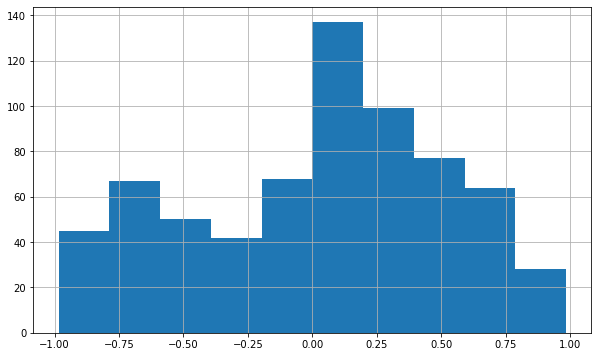

In [30]:
plt.figure(figsize=(10, 6))
df_twitter.score.hist();

In [31]:
%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

regressor = RandomForestRegressor(n_estimators=100)
target = df_twitter.score.to_numpy()
X = np.array(df_twitter.embedding.to_list())

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.1, random_state=42)


Wall time: 0 ns


In [32]:
regressor.fit(X_train, target_train)

RandomForestRegressor()

In [33]:
predicttions = regressor.predict(X_test)

In [34]:
print (f'train score: {regressor.score(X_train,target_train):.2f}')
print (f'test score: {regressor.score(X_test,target_test):.2f}')


train score: 0.92
test score: 0.47


Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

In [35]:
%%time
tokens_set = set(df_twitter.token.values)

missing_tokens = []

for key in list(words_vocab.keys()):
    if (key not in tokens_set):
        missing_tokens.append(key)

Wall time: 3.31 ms


In [36]:
len(missing_tokens), len(words_vocab.keys())

(5365, 5987)

In [37]:
%%time
missing_tokens_embeddings = np.array([word_embeddings.wv[w] for w in missing_tokens])
missing_tokens_predictions = regressor.predict(missing_tokens_embeddings)
df_missing_sentiments =  pd.Series(missing_tokens_predictions, index=missing_tokens)

Wall time: 232 ms


In [38]:
df_missing_sentiments.sort_values(ascending=False)

harmony     0.653147
blessed     0.592553
joy         0.562680
miracle     0.560807
grateful    0.539542
              ...   
suffer     -0.649050
betrayal   -0.655175
guilt      -0.661846
rape       -0.669018
raped      -0.673520
Length: 5365, dtype: float64

As we can we from the scores above the sentiment prediction seems to work :)

### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. You are encouraged to try that color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

In [39]:
%%time
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=3000)
frequent_words = vectorizer.fit_transform(df_lyrics['clean_lyrics'].apply(lambda x: (' '.join(x))).values)

Wall time: 17.8 s


In [40]:
frequent_words = frequent_words.toarray()
print(frequent_words.shape)
frequent_words

(49976, 3000)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [41]:
genres = np.unique(df_lyrics.genre.values)
genres = df_lyrics.genre.unique()
genres

array(['Pop', 'Hip-Hop', 'Rock', 'Country', 'Metal'], dtype=object)

In [42]:
word_abundance_per_genre = np.zeros((len(genres),frequent_words.shape[1]))
word_abundance_total = frequent_words.sum(axis=0)

for i, genre in enumerate(genres):
    idx = np.argwhere(df_lyrics.genre.values == genre)
    word_abundance_per_genre[i,:] = frequent_words[idx,:].sum(axis=0) / word_abundance_total

print(word_abundance_per_genre.shape)
word_abundance_per_genre

(5, 3000)


array([[0.27232143, 0.10638298, 0.16400911, ..., 0.10814607, 0.12177122,
        0.14285714],
       [0.48883929, 0.75075988, 0.39179954, ..., 0.6502809 , 0.59655597,
        0.54212454],
       [0.15848214, 0.09422492, 0.1594533 , ..., 0.10393258, 0.1100861 ,
        0.05860806],
       [0.0625    , 0.        , 0.09339408, ..., 0.0238764 , 0.00246002,
        0.        ],
       [0.01785714, 0.04863222, 0.19134396, ..., 0.11376404, 0.16912669,
        0.25641026]])

In [44]:
vector_words = np.array(list(vectorizer.vocabulary_.keys()))
vector_words.shape

(3000,)

In [45]:
word_abundance_per_genre

array([[0.27232143, 0.10638298, 0.16400911, ..., 0.10814607, 0.12177122,
        0.14285714],
       [0.48883929, 0.75075988, 0.39179954, ..., 0.6502809 , 0.59655597,
        0.54212454],
       [0.15848214, 0.09422492, 0.1594533 , ..., 0.10393258, 0.1100861 ,
        0.05860806],
       [0.0625    , 0.        , 0.09339408, ..., 0.0238764 , 0.00246002,
        0.        ],
       [0.01785714, 0.04863222, 0.19134396, ..., 0.11376404, 0.16912669,
        0.25641026]])

In [46]:
%%time
word_abundance_per_genre_sort = np.argsort(word_abundance_per_genre)
top50_words_per_genre = vector_words[word_abundance_per_genre_sort[:,-50:]]

top_significant_words = top50_words_per_genre.flatten()

top_significant_vectors = []

for word in top_significant_words:
    if word in words_vocab.keys():
        top_significant_vectors.append(word_embeddings.wv[word])

Wall time: 9.18 ms


In [47]:
word_abundance_per_genre_sort[:,-50:].shape

(5, 50)

In [48]:
top_significant_vectors = np.array(top_significant_vectors)
top_significant_vectors.shape

(250, 100)

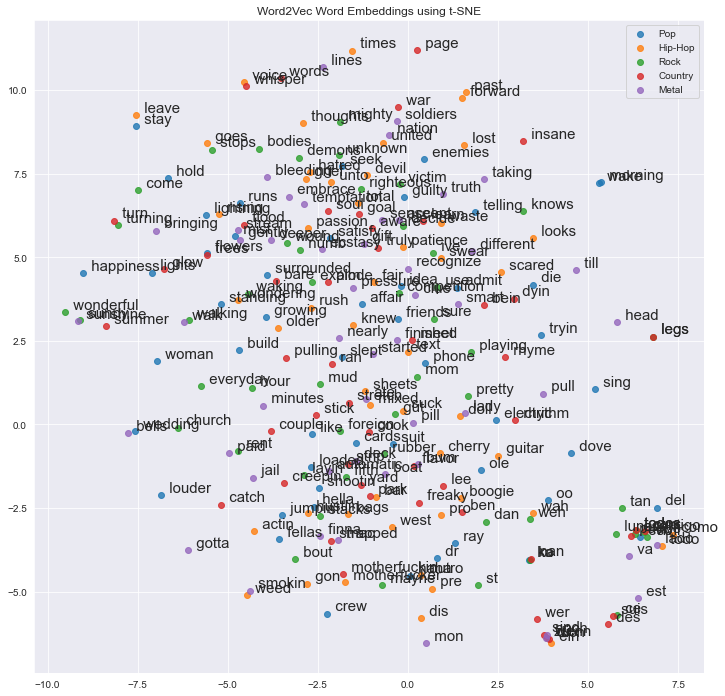

In [49]:
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.manifold import TSNE

y_tsne = TSNE(n_components=2).fit_transform(top_significant_vectors)


plt.figure(figsize=(12,12))

for i,genre in enumerate(genres):
    current_word = y_tsne[i*50:(i+1)*50,:]
    p1 = sns.regplot(current_word[:,0],current_word[:,1], fit_reg=False)
    for line in range(0, current_word.shape[0]):
        p1.text(current_word[line,0],current_word[line,1],'  ' + top50_words_per_genre[i,line],
                horizontalalignment='left',
                verticalalignment='bottom', size='medium',weight='normal').set_size(15)

plt.title('Word2Vec Word Embeddings using t-SNE')
plt.legend(genres);

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

In [50]:
%%time
vectorizer = CountVectorizer(stop_words='english')
X_train, X_test, y_train, y_test = \
    train_test_split(df_lyrics.clean_lyrics.apply(lambda x: (' '.join(x))).values, df_lyrics.genre, test_size=0.1, random_state=0) 

train_word_count = vectorizer.fit_transform(X_train)
test_word_count = vectorizer.transform(X_test)

Wall time: 16.3 s


In [51]:
from sklearn.naive_bayes import MultinomialNB
clf_NB = MultinomialNB(alpha=1)
clf_NB.fit(train_word_count, y_train)

MultinomialNB(alpha=1)

Show the confusion matrix.

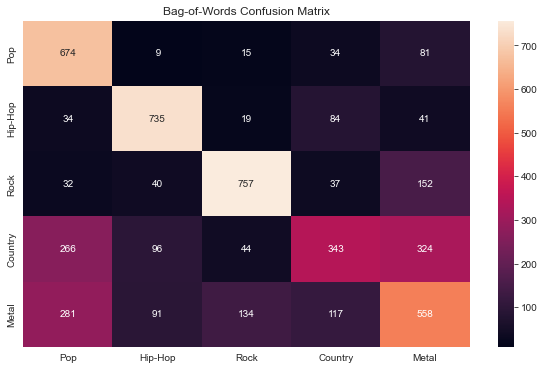

In [52]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

plt.figure(figsize=(10, 6))
y_pred = clf_NB.predict(test_word_count)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=genres, columns=genres)
sns.heatmap(df_cm, annot=True, fmt='2d')
plt.title('Bag-of-Words Confusion Matrix');


Show the classification report - precision, recall, f1 for each class.

In [53]:
from sklearn.metrics import classification_report

print( classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Country       0.52      0.83      0.64       813
     Hip-Hop       0.76      0.81      0.78       913
       Metal       0.78      0.74      0.76      1018
         Pop       0.56      0.32      0.41      1073
        Rock       0.48      0.47      0.48      1181

    accuracy                           0.61      4998
   macro avg       0.62      0.63      0.61      4998
weighted avg       0.62      0.61      0.60      4998



### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [54]:
%%time
X_train, X_test, y_train, y_test = train_test_split(df_lyrics.clean_lyrics, df_lyrics.genre, test_size=0.1) 

def calculate_mean_word_embedding(tokens):
    return np.mean(list(word_embeddings.wv[token] for token in tokens if token in word_embeddings.wv), axis=0)

X_train_word_mean = X_train.progress_apply(calculate_mean_word_embedding).to_list()
X_test_word_mean = X_test.progress_apply(calculate_mean_word_embedding).to_list()

  0%|          | 0/44978 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

Wall time: 47.8 s


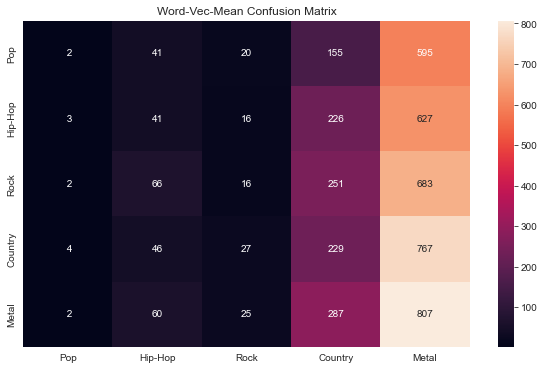

              precision    recall  f1-score   support

     Country       0.15      0.00      0.00       813
     Hip-Hop       0.16      0.04      0.07       913
       Metal       0.15      0.02      0.03      1018
         Pop       0.20      0.21      0.21      1073
        Rock       0.23      0.68      0.35      1181

    accuracy                           0.22      4998
   macro avg       0.18      0.19      0.13      4998
weighted avg       0.18      0.22      0.15      4998

Wall time: 7.17 s


In [60]:
%%time
from sklearn.linear_model import LogisticRegression
clf_LR = LogisticRegression()
clf_LR.fit(X_train_word_mean, y_train)

plt.figure(figsize=(10, 6))

y_pred = clf_LR.predict(X_test_word_mean)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=genres, columns=genres)
sns.heatmap(df_cm, annot=True, fmt='2d')
plt.title('Word-Vec-Mean Confusion Matrix')
plt.show()

print( classification_report(y_test, y_pred))

#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


In [61]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
X_train, X_test, y_train, y_test = \
    train_test_split(df_lyrics.clean_lyrics.apply(lambda x: (' '.join(x))), df_lyrics.genre, test_size=0.1, random_state=0) 

tfidf_vect = TfidfVectorizer()
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

Wall time: 15.6 s


In [62]:
%%time

def calculate_mean_word_embedding_weighted_by_tfidf(tokens, index, tfidf_weights):
    return np.mean(list(word_embeddings.wv[token] * tfidf_weights[index, tfidf_vect.vocabulary_[token]] \
        if ((token in word_embeddings.wv) and (token in tfidf_vect.vocabulary_)) else np.zeros_like(word_embeddings.wv['ooh']) for token in tokens.split()), axis=0)

X_train_weighted_word_mean = X_train.to_frame().reset_index(drop = True).progress_apply(lambda row: calculate_mean_word_embedding_weighted_by_tfidf(row.clean_lyrics, row.name, X_train_tfidf), axis=1).to_list()    
X_test_weighted_word_mean = X_test.to_frame().reset_index(drop = True).progress_apply(lambda row: calculate_mean_word_embedding_weighted_by_tfidf(row.clean_lyrics, row.name, X_test_tfidf), axis=1).to_list()

  0%|          | 0/44978 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

Wall time: 8min 10s


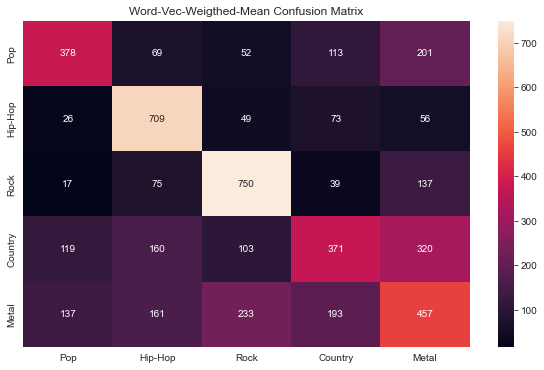

              precision    recall  f1-score   support

     Country       0.56      0.46      0.51       813
     Hip-Hop       0.60      0.78      0.68       913
       Metal       0.63      0.74      0.68      1018
         Pop       0.47      0.35      0.40      1073
        Rock       0.39      0.39      0.39      1181

    accuracy                           0.53      4998
   macro avg       0.53      0.54      0.53      4998
weighted avg       0.52      0.53      0.52      4998

Wall time: 7.48 s


In [63]:
%%time

clf_LR = LogisticRegression()
clf_LR.fit(X_train_weighted_word_mean, y_train)

plt.figure(figsize=(10, 6))

y_pred = clf_LR.predict(X_test_weighted_word_mean)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=genres, columns=genres)
sns.heatmap(df_cm, annot=True, fmt='2d')
plt.title('Word-Vec-Weigthed-Mean Confusion Matrix')
plt.show()

print( classification_report(y_test, y_pred))

### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try to answer this question without using papers or code examples.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper's code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might point you in the right direction for your own code solution.

In [121]:
df_lyrics.sent = df_lyrics.clean_lyrics.apply(lambda x: (' '.join(x)))
df_lyrics.sent 

204182    healy spoken bert healy saying singing hey hob...
6116      chorus repeat x even tryin low recognized hoes...
166369    could cause much pain leave heart rain gave ev...
198416    scarlet vision velvet room come decision dog d...
127800    sprintime savannah dont get much prettier feel...
                                ...                        
33205     men knew old love letters drawer mean nothing ...
194149    well twenty five mile drive town ther gray ski...
11649     tu viens de partir pour de longs mois c est lo...
252283    still yet gone play guitar sing songs never de...
11180     beyond reproach cool youre flawless perfect ap...
Name: sent, Length: 49976, dtype: object

In [130]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [99]:
df_lyrics.head()

,song,year,artist,genre,lyrics,num_chars,sent,num_words,clean_lyrics
204182,fully-dressed,2008,annie,Pop,[HEALY]\n[spoken] This is Bert Healy saying .....,1041,healy spoken this bert healy saying singing he...,826,"[healy, spoken, bert, healy, saying, singing, ..."
6116,surrounded-by-hoes,2006,50-cent,Hip-Hop,[Chorus: repeat 2X] Even when I'm tryin to be ...,1392,chorus repeat x even i tryin low i recognized ...,884,"[chorus, repeat, x, even, tryin, low, recogniz..."
166369,taste-the-tears-thunderpuss-remix,2006,amber,Pop,How could you cause me so much pain?\nAnd leav...,1113,how could cause much pain and leave heart rain...,756,"[could, cause, much, pain, leave, heart, rain,..."
198416,the-truth-will-set-me-free,2006,glenn-hughes,Rock,In a scarlet vision\nIn a velvet room\nI come ...,779,in scarlet vision in velvet room i come decisi...,583,"[scarlet, vision, velvet, room, come, decision..."
127800,the-last-goodbye,2008,aaron-pritchett,Country,Sprintime in Savannah\nIt dont get much pretti...,881,sprintime savannah it dont get much prettier b...,639,"[sprintime, savannah, dont, get, much, prettie..."


In [110]:
# idx2clean_lyrics = dict(enumerate(df_lyrics.clean_lyrics.apply(lambda x: (' '.join(x))).values))
# clean_lyrics2idx = {v:k for k,v in idx2clean_lyrics.items()}

In [109]:
idx2cls = dict(enumerate(df_lyrics.genre.unique()))
cls2idx = {idx:cls for cls, idx in idx2cls.items()}
idx2cls, cls2idx

({0: 'Pop', 1: 'Hip-Hop', 2: 'Rock', 3: 'Country', 4: 'Metal'},
 {'Pop': 0, 'Hip-Hop': 1, 'Rock': 2, 'Country': 3, 'Metal': 4})

In [171]:
MAX_LEN = 128  
vocab = word_embeddings.wv.index_to_key
word2idx = {w:idx  for idx, w in enumerate(vocab)}
OOV_TOKEN = "[OOV]"
OOV_IDX = len(vocab)
word2idx[OOV_TOKEN] = OOV_IDX
embedding_weights = torch.zeros(len(word_embeddings.wv.vectors)+1, word_embeddings.vector_size)
embedding_weights[:-1] = torch.FloatTensor(word_embeddings.wv.vectors)
embedding_weights[-1] = torch.zeros(word_embeddings.vector_size,)

In [172]:
# embedding_weights.shape
# embedding_weights[:-1].shape
# # embedding_weights[-1].shape
# word_embeddings.vector_size
# embedding_weights[:-1].shape

In [143]:
class SmallData(Dataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, cls2idx, max_len=128):
        self.tokenizer = nltk.WordPunctTokenizer()
        self.data = data
        self.feature_column = feature_column 
        self.target_column = target_column
        self.max_len = max_len
        self.cls2idx = cls2idx

    def __getitem__(self, item):
        text = self.data[self.feature_column].values[item]
        if not isinstance(text, str):
            text = ""
        return {"features": self.get_tokens_(text), "targets": torch.tensor([cls2idx[self.data[self.target_column].values[item]]], dtype=torch.float)}

    def get_tokens_(self, text):
        a = []
        for w in self.tokenizer.tokenize(text.strip())[:MAX_LEN]:
            if w in word2idx:
                a.append(word2idx[w])
            else:
                a.append(word2idx[OOV_TOKEN])
            ret = torch.zeros((MAX_LEN)).long()
            ret[:len(a)] = torch.tensor(a)
        return ret
        
    def __len__(self):
        return self.data.shape[0]

In [145]:
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import functional as F

X_train, X_test, y_train, y_test = train_test_split(df_lyrics, df_lyrics.genre, test_size=0.1, random_state=42)
train_dataset = SmallData(X_train, "sent", "genre", cls2idx)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = SmallData(X_test, "sent", "genre", cls2idx)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [173]:
class ConvNet(nn.Module):
    def __init__(
        self,
        emb_dim,
        out_channels,
        kernel_sizes,
        embedding_weights,
        dropout = 0.5,
        dim = 300,
        num_classes=5,
        freeze=True
    ):
        super().__init__()

        self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze)
        self.conv_0 = nn.Conv2d(in_channels = 1, out_channels = out_channels, kernel_size = (kernel_sizes[0], dim))
        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = out_channels, kernel_size = (kernel_sizes[1], dim))
        self.conv_2 = nn.Conv2d(in_channels = 1, out_channels = out_channels, kernel_size = (kernel_sizes[2], dim))
        self.fc = nn.Linear(len(kernel_sizes) * out_channels, num_classes)
        
        self.dropout = nn.Dropout(dropout)
        self.init_weights()
        
    def forward(self, text):
        
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)
        
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
            
        return self.fc(cat)
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

#### Frozen weights

In [190]:
def eval_cnn(freeze_weights):
    min_loss = np.inf
    metric_history = {"train":[], "val":[]} 
    cur_patience = 0
    cnn_model = ConvNet(emb_dim=word_embeddings.vector_size, out_channels=64, kernel_sizes=[3, 4, 5], embedding_weights=embedding_weights, dropout=0.5, dim = 100, freeze = freeze_weights).to(device)
    optimizer = torch.optim.Adam(cnn_model.parameters())
    max_epochs = 5
    loss_func = nn.CrossEntropyLoss()
    patience = 5
    max_acc = 0.0
    train_acc = 0.0
    val_acc = 0.0

    for epoch in tqdm(range(1, max_epochs + 1)):
        train_loss = 0.0
        train_accuracy = torchmetrics.Accuracy().to(device)
        cnn_model.train()
        pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=True)
        pbar.set_description(f"Epoch {epoch}")
        for it, batch in pbar: 
            optimizer.zero_grad()
            features = batch["features"].to(device)
            logits = F.softmax(cnn_model(features), dim=1)
            targets = batch["targets"].squeeze().long().to(device)
            batch_acc = train_accuracy(logits, targets)
            loss = loss_func(logits, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += batch_acc.item()

        train_loss /= len(train_dataloader)
        train_acc = train_accuracy.compute()
        metric_history["train"].append({"epoch": epoch,"loss":train_loss, "acc":train_acc.item()})

        val_loss = 0.0
        val_accuracy = torchmetrics.Accuracy().to(device)
        cnn_model.eval()
        pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader), leave=False)
        pbar.set_description(f"Epoch {epoch}")
        for it, batch in pbar:
            features = batch["features"].to(device)
            predictions = cnn_model(features)
            targets = batch["targets"].squeeze().long().to(device)
            logits = F.softmax(predictions, dim=1)
            batch_acc = val_accuracy(logits, targets)
            loss = loss_func(logits, targets)
            val_loss += loss.item()
            val_acc += batch_acc.item()

        val_loss /= len(test_dataloader)
        val_acc = val_accuracy.compute()
        metric_history["val"].append({"epoch": epoch,"loss":val_loss, "acc":val_acc.item()})
        if val_acc > max_acc:
            max_acc = val_acc
            best_model = cnn_model.state_dict()
        else:
            cur_patience += 1
            if cur_patience == patience:
                cur_patience = 0
                break

        print(f'Epoch: {epoch}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}, train acc: {train_acc:.4f}, val acc: {val_acc:.4f}')
    # cnn_model.load_state_dict(best_model)
    return metric_history

Wall time: 0 ns


In [ ]:
%%time
metric_history = eval_cnn(freeze_weights = True)

In [194]:
from matplotlib.ticker import MaxNLocator

def plot_learning_curves(metric_history, title=""):
    with plt.style.context('seaborn-whitegrid'):
        fig,ax = plt.subplots(1,2, figsize=(16, 6))
        train_history = pd.DataFrame(metric_history["train"]).reset_index()
        val_history = pd.DataFrame(metric_history["val"]).reset_index()
        train_history.plot(x="epoch", y="acc", ax=ax[0], color="r", label="train") 
        val_history.plot(x="epoch", y="acc", ax=ax[0], color="b", label="val")
        train_history.plot(x="epoch", y="loss", color="r", ax=ax[1], label="train")
        val_history.plot(x="epoch", y="loss", color="b", ax=ax[1], label="val")
        ax[0].set_title(f'{title} weights Accuracy')
        ax[1].set_title(f'{title} weights Loss')
        ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
        ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

        plt.show();

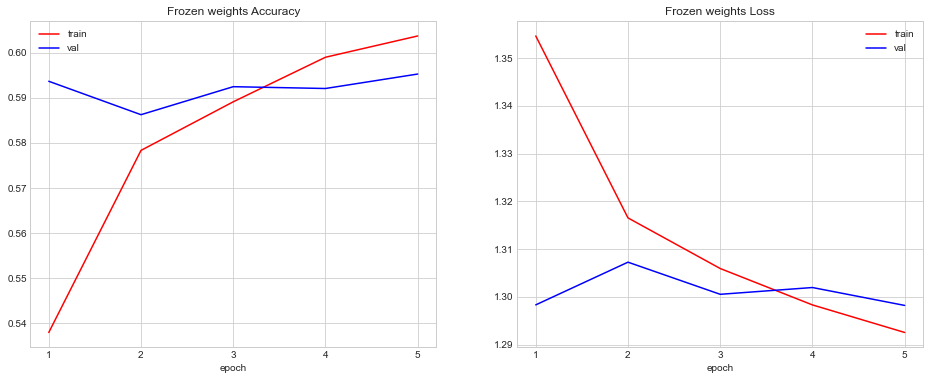

In [182]:
plot_learning_curves(metric_history, title= 'Frozen')

#### Unfrozen weights

In [191]:
%%time
metric_history = eval_cnn(freeze_weights = False)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 1, train loss: 1.329, val loss: 1.296, train acc: 0.5670, val acc: 0.6004


  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, train loss: 1.287, val loss: 1.284, train acc: 0.6092, val acc: 0.6066


  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 3, train loss: 1.265, val loss: 1.281, train acc: 0.6340, val acc: 0.6136


  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, train loss: 1.254, val loss: 1.277, train acc: 0.6450, val acc: 0.6202


  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 5, train loss: 1.239, val loss: 1.289, train acc: 0.6607, val acc: 0.6080
Wall time: 10min 50s


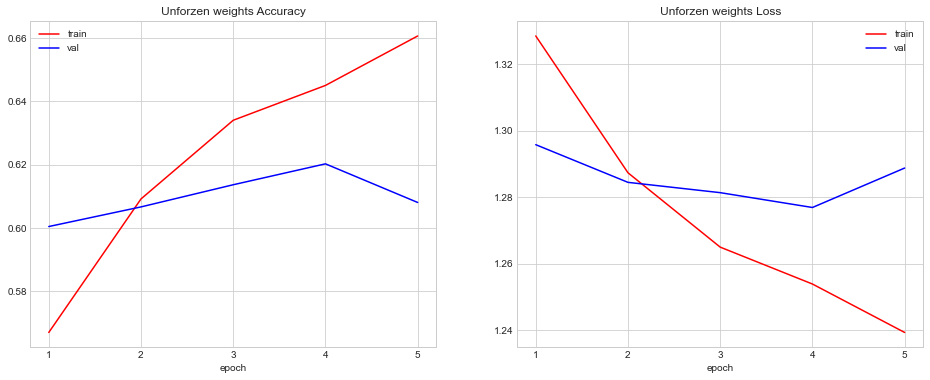

In [195]:
plot_learning_curves(metric_history, title= 'Unforzen')

**ConvNet summary**<br>
We can see that by unfreezeing the weghts we enable the model to fine tune and get better results